In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import numpy as np
import prada
import pandas as pd
import veritas
import tree_compress
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=5)
plt.rc("lines", linewidth=1.0)

## Train models

We use hyperparameter tuning using the grid below to find a reasonable model for each of the datasets.

In [3]:
dnames = ["BankMarketing", "Phoneme", "Banknote", "Spambase", "Credit", "California", "Mnist[2v4]", "Ijcnn1"]
param_dict = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.9, 0.5, 0.2, 0.1],
    "subsample": [0.25, 0.5, 0.75, 1.0],
    "max_depth": [4, 6, 8],
}

In [4]:
best_models = {}
for dname in dnames:
    d = prada.get_dataset(dname, nfolds=5, silent=True, seed=12)
    d.load_dataset()
    d.robust_normalize()
    d.astype(np.float64)

    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    
    # `model_class` can be any sklearn compatible classifier.
    # There is built-in support for
    #   - rf:  sklearn RandomForest
    #   - xgb: xgboost
    #   - lgb: lightgbm
    model_type = "xgb" # or "rf", "lgb"
    model_class = d.get_model_class(model_type)

    models = []
    for i, params in enumerate(d.paramgrid(**param_dict)):
        clf, train_time = dtrain.train(xgb.XGBClassifier, params)
    
        mtrain = dtrain.metric(clf)
        mtest  = dtest.metric(clf)
        mvalid = dvalid.metric(clf)

        models.append((d, clf, mtrain, mtest, mvalid, params))

    d, clf, mtrain, mtest, mvalid, params = max(models, key=lambda m: m[3])

    best_models[dname] = (d, clf, mtrain, mtest, mvalid, params)
    print(f"BEST {dname:10s} train acc {mtrain*100:.1f}%, test acc {mtest*100:.1f}%")
    print("params", params)
    print()

BEST BankMarketing train acc 87.4%, test acc 81.6%
params {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.75, 'max_depth': 6}

BEST Phoneme    train acc 100.0%, test acc 91.5%
params {'n_estimators': 200, 'learning_rate': 0.1, 'subsample': 0.75, 'max_depth': 8}

BEST Banknote   train acc 100.0%, test acc 100.0%
params {'n_estimators': 50, 'learning_rate': 0.9, 'subsample': 1.0, 'max_depth': 4}

BEST Spambase   train acc 100.0%, test acc 95.5%
params {'n_estimators': 200, 'learning_rate': 0.2, 'subsample': 0.75, 'max_depth': 6}

BEST Credit     train acc 78.8%, test acc 78.1%
params {'n_estimators': 50, 'learning_rate': 0.1, 'subsample': 0.75, 'max_depth': 4}

BEST California train acc 99.4%, test acc 91.2%
params {'n_estimators': 200, 'learning_rate': 0.1, 'subsample': 1.0, 'max_depth': 8}

BEST Mnist[2v4] train acc 100.0%, test acc 99.7%
params {'n_estimators': 50, 'learning_rate': 0.5, 'subsample': 1.0, 'max_depth': 4}

BEST Ijcnn1     train acc 100.0%, test acc 99.2%
para

## Compress the models using `tree_compress`

In [5]:
compressed_models = {}
for dname, (d, clf, mtrain, mtest, mvalid, params) in best_models.items():
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    data = tree_compress.Data(
        dtrain.X.to_numpy(), dtrain.y.to_numpy(),
        dtest.X.to_numpy(), dtest.y.to_numpy(),
        dvalid.X.to_numpy(), dvalid.y.to_numpy()
    )
    
    compressed_models[dname] = tree_compress.compress_topdown(
        data, clf, relerr=0.02, silent=True, max_rounds=2,
        return_compress_object=True
    )

    before = compressed_models[dname].records[0]
    after = compressed_models[dname].records[-1]
    print(f"{dname:10s} number of non-zero leaves: {before.nnz_leafs} -> {after.nnz_leafs},",
          f"test accuracy: {before.mtest*100:.1f}% -> {after.mtest*100:.1f}%")


| XGBOOST's base_score
|   base_score diff std      5.105139060270292e-07 OK
|   base_score reported      0.50015754
|   versus manually detected 0.0006300707759214674
|   abs err                  0.49952746922407854
|   rel err                  0.9987402553684955
|   (!) base_score NOT THE SAME with relative tolerance 0.001

BankMarketing number of non-zero leaves: 3803 -> 45, test accuracy: 81.6% -> 78.9%

| XGBOOST's base_score
|   base_score diff std      9.871994976448305e-07 OK
|   base_score reported      0.69284296
|   versus manually detected 0.8134441775320453
|   abs err                  0.12060121753204534
|   rel err                  0.1740671761058889
|   (!) base_score NOT THE SAME with relative tolerance 0.002

Phoneme    number of non-zero leaves: 9342 -> 84, test accuracy: 91.5% -> 87.6%

| XGBOOST's base_score
|   base_score diff std      1.6090301100389361e-06 OK
|   base_score reported      0.57230514
|   versus manually detected 0.2912620523320511
|   abs err    

## Plot the results

An open issue: ijcnn1 is an imbalanced dataset. The drop of 2% of accuracy is more severe for ijcnn1 than for the other datasets.
We should be able to configure:

- custom metric to choose alpha
- use class weights in linear classifier

We could, of course, also use a lower `relerr` for ijcnn1, but we are using the same value for all datasets here.

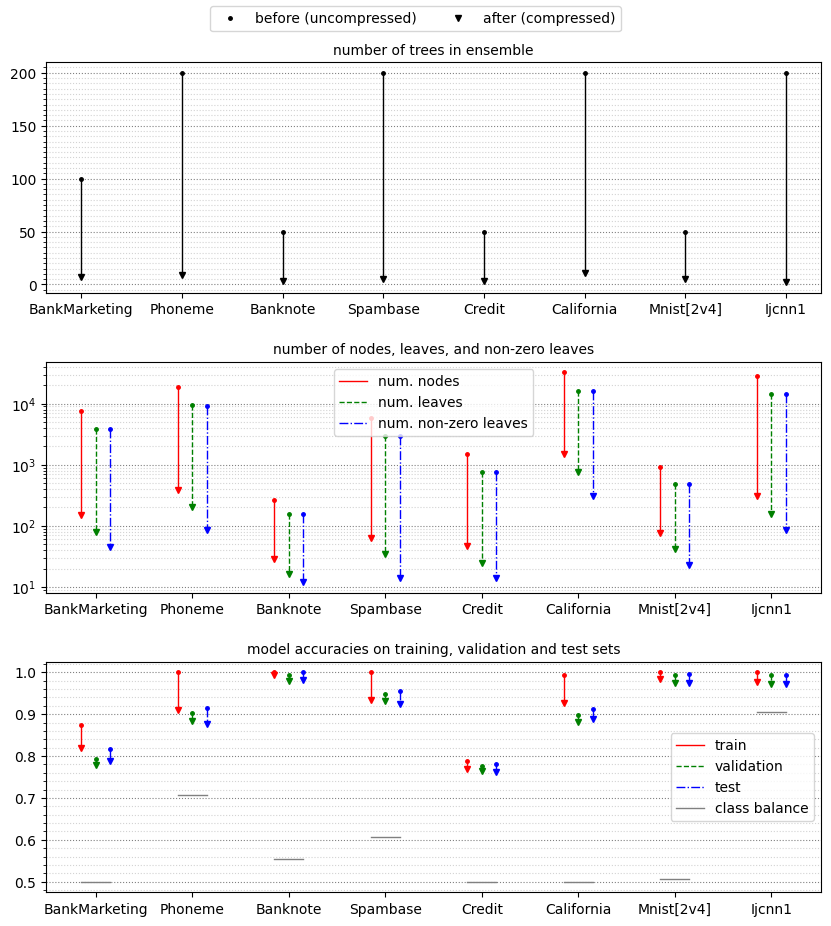

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

#for k, (dname, c) in enumerate(compressed_models.items()):
for k, dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(range(len(compressed_models)),
                                                                compressed_models.keys(),
                                                                compressed_models.values(),
                                                                best_models.values()):
    before = c.records[0]
    after = c.records[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "v", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "v", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "v", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

    class_balance = d.y.mean()
    class_balance = max(1-class_balance, class_balance)
    axs[2].plot([i, j], [class_balance, class_balance], "-", c="gray")

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(compressed_models)))
    axs[k].set_xticklabels(list(compressed_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("model accuracies on training, validation and test sets")

axs[1].set_yscale("log")
axs[0].yaxis.set_minor_locator(MultipleLocator(5))
axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

**Tabulate** the same results. We use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.

In [7]:
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test",
                                "ntrees", "nnodes", "nleaves", "nnz_leaves",
                                "nleaf_ratio", "nnz_ratio",
                                "test_ratio"], index=index_acc)

for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs
    rafter[ "nleaf_ratio"] = np.round(before.nleafs / after.nleafs, 2)
    rafter[ "nnz_ratio"] = np.round(before.nnz_leafs / after.nnz_leafs, 2)
    rafter[ "test_ratio"] = 1.0-np.round(after.mtest / before.mtest, 4)

display(df)
df_after = df.xs("after", level=1)
display(df_after[["nleaf_ratio", "nnz_ratio", "test_ratio"]].mean(axis=0))

train validation   test ntrees nnodes nleaves  \
BankMarketing before   87.4       79.4   81.6    100   7510    3805   
              after    81.9       77.9   78.9      7    149      78   
Phoneme       before  100.0       90.2   91.5    200  18490    9345   
              after    90.9       88.4   87.6      9    393     201   
Banknote      before  100.0       99.3  100.0     50    262     156   
              after    99.3       97.8   98.2      3     29      16   
Spambase      before  100.0       94.8   95.5    200   5730    2965   
              after    93.3       93.0   92.4      5     63      34   
Credit        before   78.8       77.7   78.1     50   1488     769   
              after    76.8       76.5   76.1      3     47      25   
California    before   99.4       89.8   91.2    200  32452   16326   
              after    92.7       88.0   88.7     11   1495     753   
Mnist[2v4]    before  100.0       99.3   99.7     50    934     492   
              after    98.3       97.4   97.5      5     77      41   
Ijcnn1        before  100.0       99.2   99.2    200  28524   14362   
              after    97.6       97.3   97.3      2    310     156   

                     nnz_leaves nleaf_ratio nnz_ratio test_ratio  
BankMarketing before       3803           -         -          -  
              after          45       48.78     84.51      0.033  
Phoneme       before       9342           -         -          -  
              after          84       46.49    111.21     0.0425  
Banknote      before        156           -         -          -  
              after          12        9.75      13.0     0.0182  
Spambase      before       2965           -         -          -  
              after          14       87.21    211.79      0.033  
Credit        before        769           -         -          -  
              after          14       30.76     54.93      0.026  
California    before      16323           -         -          -  
              after         303       21.68     53.87     0.0271  
Mnist[2v4]    before        492           -         -          -  
              after          23        12.0     21.39     0.0214  
Ijcnn1        before      14358           -         -          -  
              after          85       92.06    168.92     0.0196

nleaf_ratio    43.59125
nnz_ratio       89.9525
test_ratio       0.0276
dtype: object

## Verifiability: how many output configurations (OCs)?

If we can enumerate all the OCs in 5 minutes, then we consider the models tractably verifiable.
We can enumerate all the output configurations using [Veritas](https://github.com/laudv/veritas).

In [8]:
for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    print("*", dname)
    at_pruned = after.at

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.stop_when_optimal = False
    search = config.get_search(at_pruned)

    while search.steps(1000) != veritas.StopReason.NO_MORE_OPEN \
            and search.time_since_start() < 5*60.0:
        pass
        #print("Veritas", search.num_solutions(), search.num_open())
    print("  number of OCs", search.num_solutions())
    print("  number of unexplored open states (should be 0)", search.num_open())


* BankMarketing
  number of OCs 3411
  number of unexplored open states (should be 0) 0
* Phoneme
  number of OCs 31125
  number of unexplored open states (should be 0) 0
* Banknote
  number of OCs 39
  number of unexplored open states (should be 0) 0
* Spambase
  number of OCs 2402
  number of unexplored open states (should be 0) 0
* Credit
  number of OCs 82
  number of unexplored open states (should be 0) 0
* California
  number of OCs 1979722
  number of unexplored open states (should be 0) 313514
* Mnist[2v4]
  number of OCs 3608
  number of unexplored open states (should be 0) 0
* Ijcnn1
  number of OCs 1535
  number of unexplored open states (should be 0) 0


## Checking robustness on the test set

We compute the adversarial accuracy on the original model, and on the pruned model.
We ask the questions:

- How much faster can we do this on the pruned dataset?
- How does pruning affect the robustness of the models?

In [9]:
delta = 0.05
robustness = {}

for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(),
                                                             compressed_models.values(),
                                                             best_models.values()):
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    before = c.records[0]
    after = c.records[-1]

    #print()
    #veritas.test_conversion(before.at, dtest.X.to_numpy(), clf.predict_proba(dtest.X)[:,1])

    print("*", dname)

    total_time = [0.0, 0.0]
    count = [0, 0]
    count_wrong = [0, 0]
    count_nonrobust = [0, 0]
    count_to = [0, 0]

    for i in range(min(2000, dtest.X.shape[0])):
        example = dtest.X.iloc[i, :].to_numpy()
        true_label = int(dtest.y.iloc[i])
        prune_box = [veritas.Interval(x-delta, x+delta) for x in example]

        for k, at in enumerate([before.at, after.at]):
            count[k] += 1
            pred_label = int(at.predict(example)[0][0] >= .5)
    
            if true_label != pred_label:
                count_wrong[k] += 1
                continue
    
            heur = veritas.HeuristicType.MIN_OUTPUT if pred_label \
                   else veritas.HeuristicType.MAX_OUTPUT
    
            config = veritas.Config(heur)
            config.ignore_state_when_worse_than = 0.0
            search = config.get_search(at, prune_box)
    
            stop_reason = veritas.StopReason.NONE
        
            while search.num_solutions() == 0 \
                    and stop_reason == veritas.StopReason.NONE \
                    and search.time_since_start() < 5.0:
                stop_reason = search.steps(1000)
    
            total_time[k] += search.time_since_start()
    
            raw_pred = 0.0
            if search.num_solutions() > 0:
                adv_example = veritas.get_closest_example(search.get_solution(0), example, 1e-4)
                wrong_label = int(at.predict(adv_example)[0][0] >= .5)
                #data = np.vstack([example.reshape(1, -1), adv_example.reshape(1, -1)])
                #raw_pred_example, raw_pred_adv = at.eval(data)[:, 0]
                assert wrong_label != pred_label
                count_nonrobust[k] += 1
            if search.time_since_start() >= 5.0:
                count_to[k] += 1
        
        #print(i, f"lab={label}, adv={wrong_label} {raw_pred:5.3f}", search.num_solutions())
    print(f"  TOTAL TIME before {total_time[0]:.4f}s after {total_time[1]:.4f}s",
          f"({total_time[0]/total_time[1]:.1f}x)")
    print(f"  ROBUSTNESS before nonrobust {count_nonrobust[0]:4d}, incorrect {count_wrong[0]:4d}, timeout {count_to[0]:4d} ({count[0]})",
          f"adv acc={100*(1.0-(count_nonrobust[0]+count_wrong[0])/(count[0])):.1f}%")
    print(f"              after nonrobust {count_nonrobust[1]:4d}, incorrect {count_wrong[1]:4d}, timeout {count_to[1]:4d} ({count[1]})",
          f"adv acc={100*(1.0-(count_nonrobust[1]+count_wrong[1])/(count[1])):.1f}%")

    robustness[dname] = [{
        "total_time": total_time[k],
        "count_nonrobust": count_nonrobust[k],
        "count_wrong": count_wrong[k],
        "count_to": count_to[k],
        "count": count[k],
    } for k in range(2)]

* BankMarketing
  TOTAL TIME before 1.3140s after 0.0378s (34.8x)
  ROBUSTNESS before nonrobust  611, incorrect  371, timeout    0 (2000) adv acc=50.9%
              after nonrobust  435, incorrect  423, timeout    0 (2000) adv acc=57.1%
* Phoneme
  TOTAL TIME before 7.3930s after 0.0483s (153.2x)
  ROBUSTNESS before nonrobust  457, incorrect   92, timeout    0 (1080) adv acc=49.2%
              after nonrobust  270, incorrect  135, timeout    0 (1080) adv acc=62.5%
* Banknote
  TOTAL TIME before 0.0054s after 0.0020s (2.7x)
  ROBUSTNESS before nonrobust   15, incorrect    0, timeout    0 (274) adv acc=94.5%
              after nonrobust   19, incorrect    5, timeout    0 (274) adv acc=91.2%
* Spambase
  TOTAL TIME before 5.4216s after 0.0276s (196.5x)
  ROBUSTNESS before nonrobust  365, incorrect   41, timeout    0 (920) adv acc=55.9%
              after nonrobust   74, incorrect   70, timeout    0 (920) adv acc=84.3%
* Credit
  TOTAL TIME before 0.1200s after 0.0164s (7.3x)
  ROBUSTN

In [10]:
# Tabulate
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
dfrob = pd.DataFrame("-", columns=["wrong", "nonrobust", "total", "adv.acc", "time", "speedup"], index=index_acc)

for k, (dname, results) in enumerate(robustness.items()):
    before = c.records[0]
    after = c.records[-1]

    for j, jj, res in zip(range(2), ["before", "after"], results):
        r = dfrob.loc[(dname, jj), :]
        rafter = dfrob.loc[(dname, "after"), :]

        r["wrong"] = res["count_wrong"]
        r["nonrobust"] = res["count_nonrobust"]
        r["total"] = res["count"]
        #r["timeout"] = res["count_to"]
        r["adv.acc"] = np.round(100.0 - 100*(res["count_wrong"] + res["count_nonrobust"]) / res["count"], 1)
        r["time"] = np.round(res["total_time"], 2)

    dfrob.loc[(dname, "after"), "speedup"] = np.round(results[0]["total_time"] / results[1]["total_time"], 1)

display(dfrob)

wrong nonrobust total adv.acc   time speedup
BankMarketing before   371       611  2000    50.9   1.31       -
              after    423       435  2000    57.1   0.04    34.8
Phoneme       before    92       457  1080    49.2   7.39       -
              after    135       270  1080    62.5   0.05   153.2
Banknote      before     0        15   274    94.5   0.01       -
              after      5        19   274    91.2    0.0     2.7
Spambase      before    41       365   920    55.9   5.42       -
              after     70        74   920    84.3   0.03   196.5
Credit        before   442       277  2000    64.0   0.12       -
              after    479       151  2000    68.5   0.02     7.3
California    before   161      1002  2000    41.8  21.89       -
              after    216       735  2000    52.4   0.24    90.4
Mnist[2v4]    before     7       831  2000    58.1   5.76       -
              after     48      1017  2000    46.8   0.17    33.5
Ijcnn1        before    15       157  2000    91.4   8.08       -
              after     52        99  2000    92.4   0.09    86.2

We again use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.